In [2]:
import os
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.multitest import multipletests

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams 
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 8
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [4]:
def get_bindf(chromsize_file,res):
    '''
    generated chromosome bins within specific resolution
    '''
    chromsize=pd.read_csv(chromsize_file,sep='\t',header=None,usecols=[0,1])
    chromsize.columns=['chrom','length']
    chromsize=chromsize.head(23)

    bindf=pd.DataFrame()
    for i in range(len(chromsize)):
        c=chromsize.loc[i,"chrom"]
        clen=chromsize.loc[i,"length"]
        cbin=list(range(0,clen,res))
        if cbin[-1]<clen:
            cbin.append(clen)
        cdf=pd.DataFrame({'chrom':[c]*(len(cbin)-1),'start':cbin[:-1],'end':cbin[1:]})
        bindf=pd.concat([bindf,cdf],ignore_index=True)
        #print(c,clen,cbin)
    bindf['bin']=bindf['start']
    intcol=['start','end','bin']
    bindf[intcol]=bindf[intcol].astype(int)
    bindf['chrom']=bindf['chrom'].astype(str)
    return bindf

def get_bincontact(bincontact_file, bindf, ds_rate=1):
    '''
    Loading bincontact files
    '''
    bindf["freq"] = 0
    binfreq_dict = bindf.set_index(["chrom", "bin"])["freq"].to_dict()
    freqsum = 0
    with gzip.open(bincontact_file, "rt") as f:
        for line in f:
            linelist = line.strip().split("\t") # ['chrom1','bin1','chrom2','bin2','freq'] 
            chrom1, chrom2 = linelist[0], linelist[2]
            if chrom1 == chrom2:
                bin1, bin2, freq = int(linelist[1]), int(linelist[3]), int( linelist[4] )
                freqsum += freq
                binfreq_dict[(chrom1, bin1)] += freq
                binfreq_dict[(chrom2, bin2)] += freq
    # bin freq summary
    cfreq=pd.DataFrame({"freq": binfreq_dict.values()}, index=binfreq_dict.keys())
    cfreq = cfreq.reset_index(drop=False)
    cfreq.columns=['chrom','bin','freq']
    cfreq["freq"] = (cfreq.freq.values * ds_rate).round()
    print(f"{bincontact_file} : {int(freqsum*ds_rate)}  cis-contacts")
    return(cfreq)


def ResEva(cfreq, thred = 1000 ):
    '''
    Evaluate the bins to determine if they passed the  frequence  thresthold
    '''
    cfreq["Eva"] = 0
    P = cfreq.freq >= thred
    cfreq.loc[P, "Eva"] = 1
    passratio = 100 * sum(cfreq.Eva) / len(cfreq)
    return(passratio)

def main(chromsize_file, bincontact_file, rtag, ds_rate=1):
    # bins
    res = res_dict[rtag]
    bindf=get_bindf(chromsize_file,res)
    
    # bin contact frequence and  pass ration
    #contact_df = get_bincontact(bincontact_file)
    #cfreq_df = get_freq(contact_df, bindf)
    cfreq_df = get_bincontact(bincontact_file, bindf, ds_rate)
    contact_df = None
    pratio = ResEva(cfreq_df)
    return(pratio)

In [5]:
Rawdir="/data2/Hap3D_Figures/figure_processing_data/Fig5"
outdir="/data2/Hap3D_Figures/pdf/"

In [6]:
chromsize_file=f'{Rawdir}/hs37d5.fa.fai'
res_list = []

In [ ]:
res_dict={'5k':5000, '10k':10000,'25k':25000, '50k':50000, '100k':100000, '500k':500000}
for rtag, res in res_dict.items():
    ## hic h1  877.5X downsampling to 531.1X, ds_rate = 0.605
    ds_rate = 0.605
    bincontact_file=f'{Rawdir}/ginteractions/{rtag}/hic_h1.txt.gz'
    pratio = main(chromsize_file, bincontact_file, rtag, ds_rate)
    res_list.append( ["hic_ds", "h1", rtag, pratio] )
    
    ## hic h2
    bincontact_file=f'{Rawdir}/ginteractions/{rtag}/hic_h2.txt.gz'
    pratio = main(chromsize_file, bincontact_file, rtag, ds_rate)
    res_list.append( ["hic_ds", "h2", rtag, pratio] )

    ## porec h1 # 190X PoreC data
    res = res_dict[rtag]
    bincontact_file=f'{Rawdir}/ginteractions/{rtag}/porec_origin_ginteractions_h1.txt.gz'
    pratio = main(chromsize_file, bincontact_file, rtag, 1)
    res_list.append( ["porec_org", "h1", rtag, pratio] )

    ## porec h2
    res = res_dict[rtag]
    bincontact_file=f'{Rawdir}/ginteractions/{rtag}/porec_origin_ginteractions_h2.txt.gz'
    pratio = main(chromsize_file, bincontact_file, rtag, 1)
    res_list.append( ["porec_org", "h2", rtag, pratio] )

res1000_df = pd.DataFrame(res_list)
res1000_df.columns = ["method", "hap", "resolution", "percentage"]

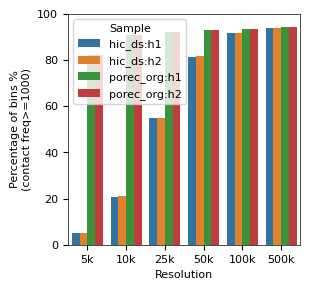

In [428]:
## bin resolution plot
plot_df = res1000_df.copy()
plot_df = plot_df.loc[plot_df.method != "hic", :]
plot_df = plot_df.loc[plot_df.method != "porec", :]

res2x = {"5k":0, "10k":1, "25k":2, "50k":3, "100k":4, "500k":5}
plot_df["Rx"] = plot_df["resolution"].apply(lambda x: res2x[x])
plot_df["Sample"] = plot_df["method"] + ":" + plot_df["hap"]
plot_df = plot_df.sort_values(by=["method","Rx"]).reset_index(drop=True)

plt.figure(figsize = (3,3)) 
#freq_plot=sns.lineplot(data=plot_df,x='Rx',y='ratio',hue='method')
freq_plot=sns.barplot(data=plot_df,x='resolution',y='percentage',hue='Sample')
#plt.xlim(0,12000)
plt.ylim(0,100)
plt.ylabel("Percentage of bins %\n(contact freq>=1000)")
plt.xlabel("Resolution")

## output
fig=outdir+'percentage_of_1000freq_bins_orignporec_dshic.pdf'
plt.savefig(fig, dpi=300,bbox_inches='tight')

In [463]:
# Contact frequence 
rtag, RES = "5k", 5000
chromsize_file=f'{Rawdir}/hs37d5.fa.fai'
bindf=get_bindf(chromsize_file,RES)

bincontact_file=f'{Rawdir}/ginteractions/{rtag}/hic_h1.txt.gz'
hic_h1_cfreq=get_bincontact(bincontact_file, bindf)
bincontact_file=f'{Rawdir}/ginteractions/{rtag}/hic_h2.txt.gz'
hic_h2_cfreq=get_bincontact(bincontact_file, bindf)

bincontact_file=f'{Rawdir}/ginteractions/{rtag}/porec_origin_ginteractions_h1.txt.gz'
porec_h1_cfreq=get_bincontact(bincontact_file, bindf)
bincontact_file=f'{Rawdir}/ginteractions/{rtag}/porec_origin_ginteractions_h2.txt.gz'
porec_h2_cfreq=get_bincontact(bincontact_file, bindf)


/data2/linzhuobin/Temp/3D_RepQC/All/5k/hic_h1.txt.gz : 158178595  cis-contacts
/data2/linzhuobin/Temp/3D_RepQC/All/5k/hic_h2.txt.gz : 159084324  cis-contacts
/data1/LLR/pairwise_contact/hg19/trans/porec_maternal/5000/origin_ginteractions.txt.gz : 506058404  cis-contacts
/data1/LLR/pairwise_contact/hg19/trans/porec_paternal/5000/origin_ginteractions.txt.gz : 505699408  cis-contacts


In [469]:
RES="5k"
## SimpleRepeat
dirpath=f"{Rawdir}/genome-stratifications_GRCh37/bins/{RES}/LowComplexity/"
bed_list=['GRCh37_SimpleRepeat_diTR_11to50_slop5.bed','GRCh37_SimpleRepeat_diTR_51to200_slop5.bed','GRCh37_SimpleRepeat_diTR_gt200_slop5.bed',\
          'GRCh37_SimpleRepeat_triTR_15to50_slop5.bed','GRCh37_SimpleRepeat_triTR_51to200_slop5.bed','GRCh37_SimpleRepeat_triTR_gt200_slop5.bed',\
          'GRCh37_SimpleRepeat_quadTR_20to50_slop5.bed','GRCh37_SimpleRepeat_quadTR_51to200_slop5.bed','GRCh37_SimpleRepeat_quadTR_gt200_slop5.bed',\
          'GRCh37_SimpleRepeat_homopolymer_4to6_slop5.bed','GRCh37_SimpleRepeat_homopolymer_7to11_slop5.bed','GRCh37_SimpleRepeat_homopolymer_gt11_slop5.bed']

region_dict={}
for bed_file in bed_list:
    region=bed_file.split('.')[0]
    bed_file=dirpath+bed_file
    bed=pd.read_csv(bed_file,sep='\t',usecols=[0,1,3],names=['chrom','bin','bases'])
    region_dict[region]=bed.bases
SR_df=pd.DataFrame(region_dict)
SR=SR_df.apply(lambda x: x.sum(),axis=1).to_list()


## TandemRepeats
dirpath=f"{Rawdir}/genome-stratifications_GRCh37/bins/{RES}/LowComplexity/"
bed_list=['GRCh37_AllTandemRepeats_lt51bp_slop5.bed','GRCh37_AllTandemRepeats_51to200bp_slop5.bed',\
          'GRCh37_AllTandemRepeats_201to10000bp_slop5.bed','GRCh37_AllTandemRepeats_gt10000bp_slop5.bed']

region_dict={}
for bed_file in bed_list:
    region=bed_file.split('.')[0]
    bed_file=dirpath+bed_file
    bed=pd.read_csv(bed_file,sep='\t',usecols=[0,1,3],names=['chrom','bin','bases'])
    region_dict[region]=bed.bases
TR_df=pd.DataFrame(region_dict)
TR=TR_df.apply(lambda x: x.sum(),axis=1).to_list()


## Segmentduplications
dirpath=f"{Rawdir}/genome-stratifications_GRCh37/bins/{RES}/SegmentalDuplications/"
bed_list=['GRCh37_segdups.bed']

region_dict={}
for bed_file in bed_list:
    region=bed_file.split('.')[0]
    bed_file=dirpath+bed_file
    bed=pd.read_csv(bed_file,sep='\t',usecols=[0,1,3],names=['chrom','bin','bases'])
    region_dict[region]=bed.bases
SD_df=pd.DataFrame(region_dict)
SD=SD_df.apply(lambda x: x.sum(),axis=1).to_list()

## lowmappability regions
dirpath=f"{Rawdir}/genome-stratifications_GRCh37/bins/{RES}/mappability/"
bed_list=['GRCh37_lowmappabilityall.bed']

region_dict={}
for bed_file in bed_list:
    region=bed_file.split('.')[0]
    bed_file=dirpath+bed_file
    bed=pd.read_csv(bed_file,sep='\t',usecols=[0,1,3],names=['chrom','bin','bases'])
    region_dict[region]=bed.bases
LM_df=pd.DataFrame(region_dict)
LM=LM_df.apply(lambda x: x.sum(),axis=1).to_list()
gc_bin

,chrom,bin,end,gc_ratio,GC_type,SR,TR,SD,LM,SR_type,TR_type,SD_type,LM_type
0,1,0,5000,0.000000,high,0,0,0,0,low,low,low,low
1,1,5000,10000,0.000000,high,0,0,0,0,low,low,low,low
2,1,10000,15000,0.589400,low,1149,1086,5000,4402,low,high,high,high
3,1,15000,20000,0.595200,low,1265,195,5000,4779,low,low,high,high
4,1,20000,25000,0.534600,low,1243,45,5000,5000,low,low,high,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
619145,21,48125000,48129895,0.000000,high,0,0,0,0,low,low,low,low
619146,M,0,5000,0.447200,low,0,0,0,0,low,low,low,low
619147,M,5000,10000,0.449200,low,0,0,0,0,low,low,low,low
619148,M,10000,15000,0.435800,low,0,0,0,0,low,low,low,low


In [ ]:
# Bin annotations
RES="5k"
gc_bin_file=f'{Rawdir}/genome-stratifications_GRCh37/bins/{RES}_gc.bed'
gc_bin=pd.read_csv(gc_bin_file,sep='\t')
gc_bin.columns=['chrom','bin','end','gc_ratio']
gc_group=[0,0.3,0.4,0.5,0.6,1]
gc_label=['<0.3','0.3-0.4','0.4-0.5','0.5-0.6','>0.6']
gc_bin['GC_type']=pd.cut(gc_bin.gc_ratio,gc_group,labels=gc_label)
gc_bin['SR']=SR
gc_bin['TR']=TR
gc_bin['SD']=SD
gc_bin['LM']=LM
gc_bin['GC_type']=gc_bin.gc_ratio.apply(lambda x: 'high' if x<0.4 or x>0.8 else 'low')
P = gc_bin['GC_type'] == "high"
print(f"{'GC_type'} high N={sum(P)} ({100*sum(P)/ len(P)})")

for coltag in ["SR", "TR", "SD", "LM"]:
    thred = gc_bin[coltag].quantile(0.95)
    gc_bin[f"{coltag}_type"] = "low"
    P = gc_bin[coltag] >= thred
    gc_bin.loc[P, f"{coltag}_type" ] = "high"
    print(f"{coltag} high {thred:.1f} N={sum(P)} ({100*sum(P)/ len(P):.3f})")

In [492]:
gc_bin = gc_bin.astype({"chrom":str})
hic_h1_cfreq = hic_h1_cfreq.astype({"chrom":str})
hic_h2_cfreq = hic_h2_cfreq.astype({"chrom":str})
porec_h1_cfreq = porec_h1_cfreq.astype({"chrom":str})
porec_h2_cfreq = porec_h2_cfreq.astype({"chrom":str})

In [493]:
## contact fregquence annotations
hic_h1_region=pd.merge(hic_h1_cfreq,gc_bin, on=["chrom", "bin"])
hic_h2_region=pd.merge(hic_h2_cfreq,gc_bin, on=["chrom", "bin"])

porec_h1_region=pd.merge(porec_h1_cfreq,gc_bin, on=["chrom", "bin"])
porec_h2_region=pd.merge(porec_h2_cfreq,gc_bin, on=["chrom", "bin"])

In [494]:
def GetPlotData(ColTag):
    '''
    Get plot data 
    '''
    dflist = []
    for df in [ hic_h1_region, hic_h2_region, porec_h1_region, porec_h2_region ] :
        df = df.loc[:, ["freq", ColTag]].copy()
        df.columns = ["freq", "type"]
        df["rfreq"] = df.freq.values / df.freq.mean()
        dflist.append(df)
    
    df = pd.concat(dflist)
    df["method"] = len(hic_h1_region)*["hic"] +  len(hic_h2_region)*["hic"] + len(porec_h1_region)*["porec"] + len(porec_h2_region)*["porec"] 
    df["hap"] = len(hic_h1_region)*["h1"] +  len(hic_h2_region)*["h2"] + len(porec_h1_region)*["h1"] + len(porec_h2_region)*["h2"]
    
    df = df.loc[df.type=="high", :]
    #X1 = df.loc[(df.method=="hic")&(df.type=="low"), "mod_freq"].values
    Y1 = df.loc[(df.method=="hic")&(df.type=="high"), "rfreq"].values
    #X2 = df.loc[(df.method=="porec")&(df.type=="low"), "mod_freq"].values
    Y2 = df.loc[(df.method=="porec")&(df.type=="high"), "rfreq"].values
    # pvalue
    pval = stat_pvalue(Y1,Y2)
    fc = np.median(Y2) / np.median(Y1)
    hic_df = df.loc[df.method=="hic", :]
    porec_df = df.loc[df.method=="porec", :]
    return(  df, pval, fc )

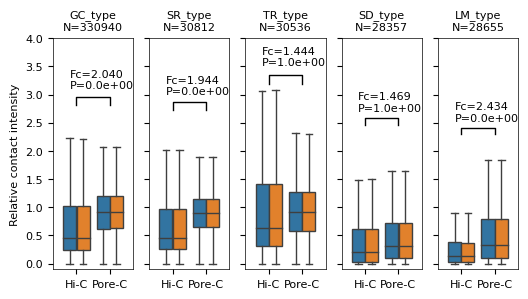

In [495]:
# Plot
outdir="/data2/linzhuobin/Hap3D_Figures/pdf"
Typelist = ["GC_type", "SR_type", "TR_type", "SD_type", "LM_type"]
num_groups = len(Typelist)
cols = 5
rows = int(  num_groups// cols )
fig, axs = plt.subplots(rows, cols, figsize=(6, 3), sharey=True)
axs = axs.flatten()

for n, ColTag in enumerate(Typelist):
    # data
    df, pval, FC  = GetPlotData(ColTag)
    sns.boxplot(data=df,x='method',y='rfreq',
                hue='hap', 
                showfliers=False, 
                ax=axs[n])
    ## plot setting
    axs[n].set_xlabel("",fontsize=8)
    if n == 0:
        axs[n].set_ylabel("Relative contact intensity",fontsize=8)
    else:
        axs[n].set_ylabel("")
    axs[n].tick_params(labelsize=8)
    axs[n].set_xticklabels(labels=["Hi-C","Pore-C"])#,rotation = 45, labels=[""]*34
    axs[n].set_title(f"{ColTag}\nN={len(df)//4}",fontsize=8)
    axs[n].get_legend().remove()
    ## fold chagne and p_value
    x1, x2 = 0, 1
    y = df["rfreq"].quantile(0.90) + 1.25
    h = y*0.05
    axs[n].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    axs[n].text((x1+x2)/2 - 0.7,y+2*h,f"Fc={FC:.3f}\nP={pval:.1e}")
    axs[n].set_ylim([-0.1, 4])
fig = outdir+"/"+"all_difficulti_v2.pdf"
plt.savefig(fig, dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
# Bin contact count distribution  50K
rtag, RES = "50k", 50000
chromsize_file=f'{Rawdir}/hs37d5.fa.fai'
bindf=get_bindf(chromsize_file,RES)
## Hic
bincontact_file=f'{Rawdir}/ginteractions/{rtag}/hic_h1.txt.gz'
hic_h1_cfreq=get_bincontact(bincontact_file, bindf)
bincontact_file=f'{Rawdir}/ginteractions/{rtag}/hic_h2.txt.gz'
hic_h2_cfreq=get_bincontact(bincontact_file, bindf)
## 160M contacts
bincontact_file=f'{Rawdir}/ginteractions/{rtag}/porec_ds_ginteractions_h1.txt.gz'
porec_h1_cfreq=get_bincontact(bincontact_file, bindf)
bincontact_file=f'{Rawdir}/ginteractions/{rtag}/porec_ds_ginteractions_h2.txt.gz'
porec_h2_cfreq=get_bincontact(bincontact_file, bindf)

In [415]:
def stat_freq(cfreq,sample, roundlevel=5 ,sigma=100):
    ## get df
    cfreq=cfreq.copy()
    q75, q25 = np.percentile(cfreq.freq.values, [75 ,25])
    iqr = q75 - q25
    ## frequence 
    legendstr = f"{sample}:{cfreq.freq.mean():.1f}±{cfreq.freq.std():.1f},{cfreq.freq.median():.0f}({ iqr:.0f})"
    print(legendstr)
    cfreq["freq"] = roundlevel* (cfreq["freq"].values / roundlevel).round() 
    freq_df = cfreq.groupby('freq')['bin'].count().reset_index()
    freq_df.columns = ['freq','count']
    freq_df['ratio']=freq_df['count']/freq_df['count'].sum()*100
    freq_df['ratio'] =  gaussian_filter1d(freq_df['ratio'].values, sigma=sigma)
    freq_df['sample']=sample
    #freq_df['ratio']=freq_df['ratio'].apply(lambda x: round(x,2))    
    return freq_df, legendstr

In [420]:
roundlevel = 10
sigma= 10
legendlist = []

hic_h1,lstr1=stat_freq(hic_h1_cfreq,'hic_HP1',roundlevel, sigma)
hic_h2,lstr2=stat_freq(hic_h2_cfreq,'hic_HP2',roundlevel, sigma)
porec_h1,lstr3=stat_freq(porec_h1_cfreq,'porec_HP1',roundlevel, sigma)
porec_h2,lstr4=stat_freq(porec_h2_cfreq,'porec_HP2',roundlevel, sigma)
legendlist = [lstr1, lstr2, lstr3, lstr4]
freq_df=pd.concat([hic_h1,hic_h2,porec_h1,porec_h2])
freq_df.reset_index(drop=True,inplace=True)


hic,lstr1=stat_freq(pd.concat([hic_h1_cfreq, hic_h2_cfreq]),'hic',roundlevel, sigma)
porec,lstr2=stat_freq(pd.concat([porec_h1_cfreq, porec_h2_cfreq]),'porec',roundlevel, sigma)

hic_HP1:5208.5±4176.0,4167(5536)
hic_HP2:5238.3±4208.7,4185(5573)
porec_HP1:5269.9±2154.0,5505(2242)
porec_HP2:5268.4±2148.2,5493(2221)
hic:5223.4±4192.4,4178(5554)
porec:5269.2±2151.1,5500(2230)


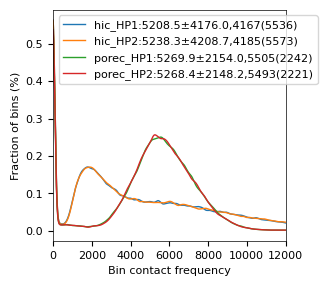

In [429]:
## basic plot
plt.figure(figsize = (3,3)) 
freq_plot=sns.lineplot(data=freq_df,x='freq',y='ratio',hue='sample')
plt.xlim(0,12000)
#plt.ylim(0,0.06)
## plot setting
# labels
freq_plot.legend(title="",bbox_to_anchor=(0.95, 0.95), loc=1, 
                 borderaxespad=0,fontsize=8,
                 title_fontsize=8,frameon=False)
freq_plot.set_xlabel("Bin contact frequency",fontsize=8)
freq_plot.set_ylabel("Fraction of bins (%)",fontsize=8)
plt.legend(legendlist)
## output
#fig=outdir+'bin_cfreq.10k.pdf'
fig=outdir+'bin_cfreq.50k_v1.pdf'
freq_plot.figure.savefig(fig, dpi=300,bbox_inches='tight')
#plt.show()

In [8]:
# Gap percentage
gr_file=f'{Rawdir}/gap_ratio.txt'
gr=pd.read_csv(gr_file, header=0, index_col=None, sep="\t")
gr

,main_region,region,Hi-C_phased(10X),Pore-C_phased(10X)
0,GC,0-15,87.82,2.04
1,GC,15-20,75.92,1.28
2,GC,20-25,69.51,1.03
3,GC,25-30,62.41,0.97
4,GC,30-55,51.97,3.10
5,GC,55-60,43.83,0.51
6,GC,60-65,47.65,0.56
7,GC,65-70,58.17,1.03
8,GC,70-75,72.53,0.70
9,GC,75-80,86.52,0.52


In [9]:
gr.loc[:,["Hi-C_phased(10X)","Pore-C_phased(10X)"]].mean()

Hi-C_phased(10X)      73.256471
Pore-C_phased(10X)     9.353824
dtype: float64

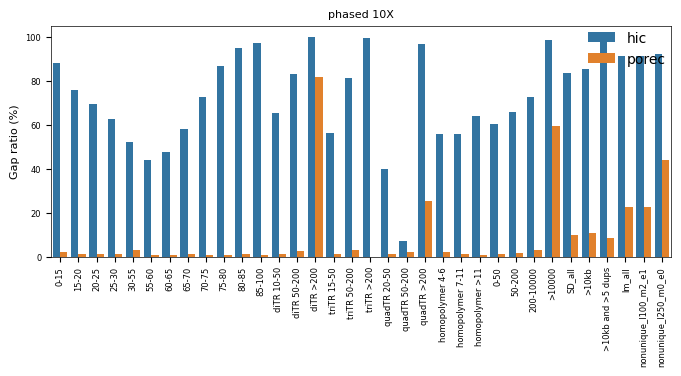

In [20]:
# Plot
outdir='/data2/linzhuobin/Hap3D_Figures/pdf'
Type =  "phased"

plt.subplots( figsize = (8,3))

xlabels=gr['region'].values

    # data
hic_df = pd.DataFrame({"region": xlabels,
                   "ratio": gr[f"Hi-C_{Type}(10X)"],
                    "method": len(xlabels)*["hic"]})
porec_df = pd.DataFrame({"region": xlabels,
                   "ratio": gr[f"Pore-C_{Type}(10X)"],
                    "method": len(xlabels)*["porec"]})
df = pd.concat([hic_df, porec_df], axis=0)

sns.barplot(data=df,x='region',y='ratio',hue='method')
## plot setting
plt.legend(loc=1, borderaxespad=0,fontsize=10,frameon=False)
#ratio_plot.legend(title="Step",bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0,fontsize=12,title_fontsize=12,frameon=False)
plt.xlabel("",fontsize=8)
plt.ylabel("Gap ratio (%)",fontsize=8)
plt.tick_params(labelsize=6)
plt.gca().set_xticklabels(labels=xlabels, rotation=90)#,rotation = 45, labels=[""]*34
plt.title(f"{Type} 10X",fontsize=8)

fig.tight_layout()
fig=outdir+"/"+"gap_ratio.10X.pdf"
plt.savefig(fig, dpi=300,bbox_inches='tight')

In [45]:
## TAD reproduced

'''
Merge all Haplotype TADs overlaped with original TADs
'''
def MergeIntTADs(hic_int_file, suffixtag, hic_tads):
    hic_int=pd.read_csv(hic_int_file,names=['chrom','start','end','rID','chrom2','start2','end2',"qID",'intersect'],header=None,sep='\t')
    hic_int[['start','end','start2','end2','intersect']]=hic_int[['start','end','start2','end2','intersect']].astype(int)
    hic_int = hic_int.loc[hic_int.chrom != "chrX", :]
    hic_int['len1']= hic_int['end'] - hic_int['start']
    hic_int['len2']= hic_int['end2'] - hic_int['start2']
    hic_int['ratio1']=hic_int['intersect']/hic_int['len1']*100
    hic_int['ratio2']=hic_int['intersect']/hic_int['len2']*100
    # Intersect TAD filter
    P = (hic_int.ratio1>=85) & (hic_int.ratio2>=85)
    hic_int = hic_int.loc[P, ['chrom','start','end','rID','chrom2','start2','end2'] ]
    hic_int.columns = ['chrom','start','end','rID',f'chrom_{suffixtag}',f'start_{suffixtag}',f'end_{suffixtag}']
    # Merge the Interset df
    hic_tads = pd.merge(hic_tads, hic_int,on=['chrom','start','end',"rID"], how="outer")
    return( hic_tads )
    

Rawdir="/data2/linzhuobin/Hap3D_Figures/figure_processing_data/Fig5"
OriginTAD = f"{Rawdir}/GSE63525_GM12878_insitu_DpnII.TAD_50k.bed"
hic_tads = pd.read_csv(OriginTAD,names=['chrom','start','end',"rID"],header=None,sep='\t')
hic_tads = hic_tads.loc[hic_tads.chrom != "chrX", :] # autochromosomes
hic_tads[['start','end', "rID"]] = hic_tads[['start','end', "rID"]].astype(int)

hic_int_file = f"{Datadir}/hic_maternal.TAD.int"
suffixtag = "HiC_ma"
hic_tads = MergeIntTADs(hic_int_file, suffixtag, hic_tads)

hic_int_file = f"{Datadir}/hic_paternal.TAD.int"
suffixtag = "HiC_pa"
hic_tads = MergeIntTADs(hic_int_file, suffixtag, hic_tads)

hic_int_file = f"{Datadir}/PoreC_maternal.TAD.int"
suffixtag = "PoreC_ma"
hic_tads = MergeIntTADs(hic_int_file, suffixtag, hic_tads)

hic_int_file = f"{Datadir}/PoreC_paternal.TAD.int"
suffixtag = "PoreC_pa"
hic_tads = MergeIntTADs(hic_int_file, suffixtag, hic_tads)

# Export
exfile = f"{Rawdir}/Overlap_of_OriginalTADs_HaplotypeTADs.csv"
hic_tads.to_csv(exfile,header=True, index=False, sep="\t")

In [22]:
# TADs
def IntCount(Hicfile, HicTADfile):
    '''
    Export Haplotype TADs overlap with ref TADs
    '''
    hic_tads = pd.read_csv(HicTADfile,names=['chrom','start','end',"qID"],header=None,sep='\t')
    hic_tads["qID"] = hic_tads["qID"].astype("str")
    hic_tads = hic_tads.loc[hic_tads.chrom != "chrX", :] # autochromosomes
    
    qID_al = set( hic_tads.qID.values )
    hic_int=pd.read_csv(Hicfile,names=['chrom1','start1','end1',"rID",'chrom2','start2','end2',"qID",'intersect'],header=None,sep='\t')
    hic_int[['start1','end1','start2','end2','intersect']]=hic_int[['start1','end1','start2','end2','intersect']].astype(int)
    hic_int = hic_int.loc[hic_int.chrom1 != "chrX", :]
    hic_int['len1']= hic_int['end1'] - hic_int['start1']
    hic_int['len2']= hic_int['end2'] - hic_int['start2']
    hic_int['ratio1']=hic_int['intersect']/hic_int['len1']*100
    hic_int['ratio2']=hic_int['intersect']/hic_int['len2']*100
    # Intersect refIDs
    P = (hic_int.ratio1>=85) & (hic_int.ratio2>=85)
    rID_al = set( hic_int.rID.unique() )
    if sum(P) > 0:
        rID_op = set( hic_int.loc[P, "rID"].unique() )
        qID_op = set( hic_int.loc[P, "qID"].unique() ) 
    else:
        rID_op = set([])
        qID_op = set([])
    print( len(rID_op), len(rID_al-rID_op),  len(qID_op), len(qID_al - qID_op) )
    return(  len(rID_op), len(rID_al-rID_op), len(qID_op), len(qID_al - qID_op) )

Countlist, Methodlist, Classlist, Haplotypelist = [], [], [], [] 

Rawdir="/data2/linzhuobin/Hap3D_Figures/figure_processing_data/Fig5"
outdir="/data2/linzhuobin/Hap3D_Figures/pdf"
# Hi-C
Hicfile = f"{Rawdir}/hic_maternal.TAD.int"
HicTADfile = f"{Rawdir}/hic_maternal.TAD_50K.bed"
counts =  IntCount(Hicfile, HicTADfile)
Countlist.extend( counts )
Haplotypelist.extend(4*["maternal"])
Methodlist.extend(4*["hic"])
Classlist.extend(["r_op","r_uniq", "q_op", "q_uniq"])

Hicfile = f"{Rawdir}/hic_paternal.TAD.int"
HicTADfile = f"{Rawdir}/hic_paternal.TAD_50K.bed"
counts =  IntCount(Hicfile, HicTADfile)
Countlist.extend( counts )
Haplotypelist.extend(4*["paternal"])
Methodlist.extend(4*["hic"])
Classlist.extend(["r_op","r_uniq", "q_op", "q_uniq"])

# Pore-C
Hicfile = f"{Rawdir}/PoreC_maternal.TAD.int"
HicTADfile = f"{Rawdir}/PoreC_maternal.TAD_50k.bed"
counts =  IntCount(Hicfile, HicTADfile)
Countlist.extend( counts )
Haplotypelist.extend(4*["maternal"])
Methodlist.extend(4*["PoreC"])
Classlist.extend(["r_op","r_uniq", "q_op", "q_uniq"])

Hicfile = f"{Rawdir}/PoreC_paternal.TAD.int"
HicTADfile = f"{Rawdir}/PoreC_paternal.TAD_50k.bed"
counts =  IntCount(Hicfile, HicTADfile)
Countlist.extend( counts )
Haplotypelist.extend(4*["paternal"])
Methodlist.extend(4*["PoreC"])
Classlist.extend(["r_op","r_uniq", "q_op", "q_uniq"])

483 1372 480 284
492 1363 491 282
1157 698 1156 351
1142 713 1142 358


In [24]:
plot_df

,method,hp,Class,count,x
0,hic,maternal,r_op,483,hic_maternal
1,hic,maternal,r_uniq,1372,hic_maternal
2,hic,maternal,q_op,480,hic_maternal
3,hic,maternal,q_uniq,284,hic_maternal
4,hic,paternal,r_op,492,hic_paternal
5,hic,paternal,r_uniq,1363,hic_paternal
6,hic,paternal,q_op,491,hic_paternal
7,hic,paternal,q_uniq,282,hic_paternal
8,PoreC,maternal,r_op,1157,PoreC_maternal
9,PoreC,maternal,r_uniq,698,PoreC_maternal


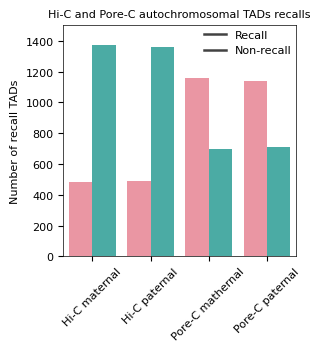

In [25]:
## Haplotype TADs
plot_df = pd.DataFrame({'method': Methodlist ,
                        'hp':Haplotypelist,
                        'Class':Classlist,
                        'count':Countlist})
plot_df["x"] = plot_df["method"] + "_" + plot_df["hp"]
P = plot_df.x.str.contains("r_")
plot_df.loc[P, :]

## basic plot(old)
plt.figure(figsize = (3,3)) 
#recall_plot=
sns.set_palette("Paired",1)
P = plot_df.Class.str.contains("r_")
plot=sns.barplot(data=plot_df.loc[P, :],x='x', y='count', hue="Class")
## plot setting
plot.legend(["Recall", "Non-recall"], loc=1, 
            borderaxespad=0,fontsize=8,frameon=False)
#ratio_plot.legend(title="Step",bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0,fontsize=12,title_fontsize=12,frameon=False)
plot.set_xlabel("",fontsize=8)
plot.set_ylabel("Number of recall TADs",fontsize=8)
plot.tick_params(labelsize=8)
plot.set_xticklabels(labels= ["Hi-C maternal", "Hi-C paternal", "Pore-C mathernal", "Pore-C paternal"], 
                     rotation = 45, fontsize=8)#,rotation = 45, labels=[""]*34
plot.set_title("Hi-C and Pore-C autochromosomal TADs recalls",fontsize=8)
plot.set_ylim((0, 1500))


fig = outdir+"/"+"haplotype.tad.comparison.pdf"
plot.figure.savefig(fig, dpi=300,bbox_inches='tight')

In [27]:
#  3D_RepQC
def get_qc(qcdir,samid,chrid):
    qc=[]
    for c in chrid:
        qcf='.'.join([c,samid,'scores.txt'])
        qcf=qcdir+qcf
        cqc=os.popen("cat %s | awk '{print $2}' "%(qcf)).read().strip()
        qc.append(cqc)
    qc_df=pd.DataFrame({'chrom':chrid,'qc_score':qc})
    return qc_df


def plot_qc(h1_qc,h2_qc,outpath):
    ## integrate
    df=pd.concat([h1_qc,h2_qc[['qc_score']]],axis=1)
    df.columns=['chrom','h1','h2']
    df[['h1','h2']]=df[['h1','h2']].astype(float)
    ## plot
    plt.figure(figsize = (6,2)) 
    plt.scatter(df.index+1,df.h1,s=10,c='g')
    plt.scatter(df.index+1,df.h2,s=10,c='r')
    plt.xticks(df.index+1)
    h1_mean,h2_mean=str(round(df.h1.mean(),4)),str(round(df.h2.mean(),4))
    maxqc=max(df.h1.max(),df.h2.max())
    h1_texty=maxqc*0.9
    h2_texty=maxqc*0.8
    plt.text(1,h1_texty,'H1='+h1_mean)
    plt.text(1,h2_texty,'H2='+h2_mean)
    plt.xlabel('Chromosome')
    plt.ylabel('QuASAR-QC scores')
    ## output
    #plt.savefig(outpath)
    return df


def stat_pvalue(xdata,ydata):
    stat,p_value = scipy.stats.ttest_ind(xdata,ydata,equal_var=False)
    return(stat,p_value)

## qc loading
def QCloading(Rawdir, resolution):
    samid='hic_h1'
    qcdir=Rawdir+'/'+resolution+'/results/qc/hic_h1/QuASAR-QC/'
    h1_qc=get_qc(qcdir,samid,chrid)
    h1_qc['method']='Hi-C'
    h1_qc['resolution']=resolution
    h1_qc['haplotype']='HP1'

    samid='hic_h2'
    qcdir=Rawdir+'/'+resolution+'/results/qc/hic_h2/QuASAR-QC/'
    h2_qc=get_qc(qcdir,samid,chrid)
    h2_qc['method']='Hi-C'
    h2_qc['resolution']=resolution
    h2_qc['haplotype']='HP2'

    samid='porec_h1'
    qcdir=Rawdir+'/'+resolution+'/results/qc/porec_h1/QuASAR-QC/'
    p1_qc=get_qc(qcdir,samid,chrid)
    p1_qc['method']='Pore-C'
    p1_qc['resolution']=resolution
    p1_qc['haplotype']='HP1'

    samid='porec_h2'
    qcdir=Rawdir+'/'+resolution+'/results/qc/porec_h2/QuASAR-QC/'
    p2_qc=get_qc(qcdir,samid,chrid)
    p2_qc['method']='Pore-C'
    p2_qc['resolution']=resolution
    p2_qc['haplotype']='HP2'
    # Merge data
    qc_df=pd.concat([h1_qc,h2_qc,p1_qc,p2_qc]).reset_index(drop=True)
    qc_df['group']=qc_df['method']+':'+qc_df['haplotype']
    qc_df['qc_score']=qc_df['qc_score'].astype(float)
    qc_df.head()
    return(qc_df)

## Quasar scores
chrid=['chr'+str(i) for i in range(1,22+1)]+['chrX']
Datadir=f"{Rawdir}/3DChromatin_ReplicateQC/compare"
qc_10k = QCloading(Datadir, "10k")
qc_50k = QCloading(Datadir, "50k")
qc_100k = QCloading(Datadir, "100k")
qc_500k = QCloading(Datadir, "500k")
qc=pd.concat([qc_500k,qc_100k,qc_50k,qc_10k]).reset_index(drop=True)


hp1_qc=qc.loc[qc.haplotype=='HP1',].reset_index(drop=True)
hp2_qc=qc.loc[qc.haplotype=='HP2',].reset_index(drop=True)

group_order=pd.CategoricalDtype(categories=["Hi-C:HP1","Pore-C:HP1","Hi-C:HP2","Pore-C:HP2"],ordered=True)
res_order=pd.CategoricalDtype(categories=["500k","100k","50k","10k"],ordered=True)

qc['group'] = qc['group'].astype(group_order)
qc['resolution'] = qc['resolution'].astype(res_order)

qc=qc.sort_values(['resolution','group'])
qc.reset_index(drop=True,inplace=True)


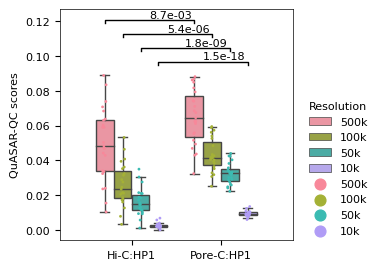

In [30]:
outdir='/data2/Hap3D_Figures/pdf/'
## basic plot
plt.figure(figsize = (3,3)) 
qc_plot=sns.boxplot(data=hp1_qc, 
                    x="group", y="qc_score",
                    hue="resolution", showfliers=False,
                    flierprops={"marker": "x"})
sns.stripplot(data=hp1_qc, 
              x="group", y="qc_score", 
              hue="resolution", dodge=True, size=2, linewidth=0)
## p value
x1=-0.3
y=hp1_qc.qc_score.max()+0.03
pvals = []
for res in ['500k','100k','50k','10k']:
    stat,p_value=stat_pvalue(hp1_qc.loc[(hp1_qc.resolution==res)&(hp1_qc.group=='Hi-C:HP1'),"qc_score"],
       hp1_qc.loc[(hp1_qc.resolution==res)&(hp1_qc.group=='Pore-C:HP1'),"qc_score"])
    pvals.append( p_value )
adjpvals = multipletests(pvals, method="fdr_bh")[1]    
    
for res, adjpval in zip( ['500k','100k','50k','10k'], adjpvals ):
    x2=1+x1
    h=0.002
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    plt.text((x1+x2)/2,y+0.003,f"{adjpval:.1e}")
    x1+=0.2
    y+=-0.008
## plot setting
# labels
qc_plot.legend(title="Resolution",bbox_to_anchor=(1.05, 0), 
               loc=3, borderaxespad=0,fontsize=8,
               title_fontsize=8,frameon=False)
qc_plot.set_xlabel("",fontsize=8)
qc_plot.set_ylabel("QuASAR-QC scores",fontsize=8)
## output
fig=outdir+'qc_resolution_Hp1_v2.pdf'
qc_plot.figure.savefig(fig, dpi=300,bbox_inches='tight')

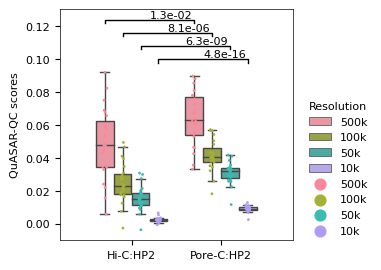

In [32]:
## basic plot
plt.figure(figsize = (3,3)) 
qc_plot=sns.boxplot(data=hp2_qc, 
                    x="group", y="qc_score",
                    hue="resolution", showfliers=False,
                    flierprops={"marker": "x"})
sns.stripplot(data=hp2_qc, 
              x="group", y="qc_score", 
              hue="resolution", dodge=True, size=2, linewidth=0)
## p value
x1=-0.3
y=hp2_qc.qc_score.max()+0.03
pvals = []
for res in ['500k','100k','50k','10k']:
    stat,p_value=stat_pvalue(hp2_qc.loc[(hp2_qc.resolution==res)&(hp2_qc.group=='Hi-C:HP2'),"qc_score"],
       hp2_qc.loc[(hp2_qc.resolution==res)&(hp2_qc.group=='Pore-C:HP2'),"qc_score"])
    pvals.append( p_value )
adjpvals = multipletests(pvals, method="fdr_bh")[1]   

for res, adjpval in zip( ['500k','100k','50k','10k'], adjpvals ):
    x2=1+x1
    h=0.002
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    plt.text((x1+x2)/2,y+0.003,f"{adjpval:.1e}")
    x1+=0.2
    y+=-0.008
## plot setting
# labels
qc_plot.legend(title="Resolution",bbox_to_anchor=(1.05, 0), 
               loc=3, borderaxespad=0,fontsize=8,
               title_fontsize=8,frameon=False)
qc_plot.set_xlabel("",fontsize=8)
qc_plot.set_ylabel("QuASAR-QC scores",fontsize=8)
## output
fig=outdir+'qc_resolution_Hp2_v2.pdf'
qc_plot.figure.savefig(fig, dpi=300,bbox_inches='tight')
